### LSTM Model for Water Tank-Reduced

Mean Squared Error: 0.00133044202812016
(8982, 5)
[[ 4.9809974e-01  3.8664204e+01 -1.6474215e-02  1.5086703e+00
   5.2293483e-03]
 [ 4.9547213e-01  3.8918831e+01 -1.4409728e-02  1.5336715e+00
  -1.2669170e-02]
 [ 4.9749076e-01  3.8896137e+01 -4.1355014e-02  1.5557166e+00
  -1.1350056e-02]
 ...
 [ 5.1383328e-01  4.3201515e+01 -7.0882320e-02  2.0263791e+00
   6.8684146e-03]
 [ 4.9453485e-01  4.3045006e+01 -1.1355104e-01  2.0095708e+00
   3.6364675e-02]
 [ 4.9417013e-01  4.3312443e+01  1.0552127e-04  2.0317867e+00
   6.4567372e-02]]
Root Mean Squared Error: 0.2887276467384341
----------Learning Curve----------


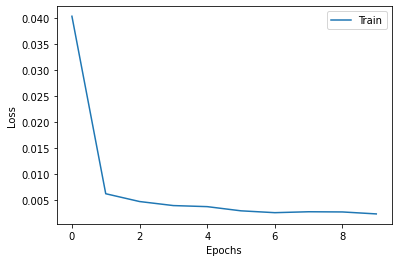

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               42400     
                                                                 
 repeat_vector_3 (RepeatVect  (None, 3, 100)           0         
 or)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 3, 100)            80400     
                                                                 
 time_distributed_3 (TimeDis  (None, 3, 5)             505       
 tributed)                                                       
                                                                 
Total params: 123,305
Trainable params: 123,305
Non-trainable params: 0
_________________________________________________________________


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

# Load and preprocess data
data = pd.read_csv('waterTank_Golden_reduced.csv', header=0, index_col=0)
raw_data = data.values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(raw_data)

# Split data into train and test sets
# train_size = int(len(data) * 0.7)
train_size = 12000
test_size = len(data) - train_size
train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data),:]

# Define the number of time steps and features
n_steps_in = 5
n_steps_out = 3
n_features = data.shape[1]

# Reshape data for LSTM
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        if out_end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix-1:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_train, y_train = split_sequence(train, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test, n_steps_in, n_steps_out)

# Define the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

# Compile and fit the model
model.compile(optimizer='adam', loss='mse')
train_history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Evaluate the model
mse = model.evaluate(X_test, y_test, verbose=0)
print('Mean Squared Error:', mse)

# Make predictions on test data
y_pred = model.predict(X_test)

# Reshape predictions for inverse scaling
# y_pred_reshaped = y_pred.reshape((y_pred.shape[0]*y_pred.shape[1], n_steps_out, n_features))
# y_test_reshaped = y_test.reshape((y_test.shape[0]*y_test.shape[1], n_steps_out, n_features))

# Extract only the result of prediction for n_steps_out=3
result_pred = y_pred[:, -n_steps_out:, :]

# Reshaping


# Inverse scale predictions and test data
result_pred_inv = scaler.inverse_transform(result_pred.reshape(-1, n_features))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, n_features))

print(result_pred_inv.shape)
print(result_pred_inv)
# Calculate RMSE
# rmse = np.sqrt(np.mean((y_pred_inv - y_test_inv)**2))
rmse = np.sqrt(np.mean((result_pred_inv - y_test_inv)**2))
print('Root Mean Squared Error:', rmse)

# Plot curve
print("----------Learning Curve----------")
plt.plot(train_history.history['loss'], label='Train')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

model.summary()